# Cherry-picking information: humans actively sample evidence to support prior beliefs

This notebook produces all the results and plots presented in Kaanders et al. (2021).

## Overview

<a href='#Figure1B'>1. Figure 1B</a><br>
[2. Figure 1C](#Figure1C)<br>
[3. T-test Accuracy Study 1](#tACCStudy1)<br>
[4. T-test Figure 1C](#tFigure1C)<br>
[5. Figure 2A](#Figure2A)<br>
[6. Figure 2B](#Figure2B)<br>
[7. Figure 2C](#Figure2C)<br>
[8. Figure 3B](#Figure3B)<br>
[9. Figure 3C](#Figure3C)<br>
[10. T-test Accuracy Study 2](#tACCStudy2)<br>
[11. T-test Figure 3C](#tFigure3C)<br>
[12. Figure 4A](#Figure4A)<br>
[13. Figure 4B](#Figure4B)<br>
[14. Figure 4C](#Figure4C)<br>
[15. Figure 4D](#Figure4D)<br>
[16. Saccades](#Saccades)<br>
[17. Figure S3.1](#FigureS3_1)<br>
[18. Figure S4.1](#FigureS4_1)<br>
[19. S7: Model Comparisons](#ModelComp)<br>
[20. Functions used](#Functions)<br>

### Load packages

In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from pandas.core.frame import DataFrame as DF
from copy import copy as copy
import operator as operator
import pylab as pl

import sys
sys.path.insert(0, '../code')

# linking to files in notebooks
from IPython.display import FileLink, FileLinks, Image

# Plotting tools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import patsy
from patsy import dmatrix, demo_data, ContrastMatrix, Poly

# Show graphs in Notebook
%matplotlib inline

%pylab inline
figsize(15, 15);

import sklearn
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import os
os.environ['R_HOME'] = '/anaconda3/lib/R'
os.environ['R_USER'] = '/anaconda3/lib/python3.7'

import rpy2.rinterface
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%%R
library(lme4)
library(nlme)
library(pbkrtest)
library(optimx)
library(RCurl)

In [3]:
%R install.packages("RCurl", repos='http://cran.us.r-project.org')

In [4]:
# hide warning messages
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

### Load data & data preparation

#### Study 1

In [5]:
# load data study 1
Data1=pd.read_csv('../data/exp1_main_data.csv')

In [6]:
subjects1=Data1['Participant'].unique() # making an array with the participant numbers

In [7]:
Data1.columns

Index(['Participant', 'Trial', 'Correct1', 'CorrectKey', 'Response1', 'RT1',
       'DotDifference', 'DotNumberRight', 'DotNumberLeft', 'Conf1', 'Conf1_RT',
       'CipResponse', 'CipRT', 'Correct2', 'Response2', 'RT2', 'Conf2',
       'Conf2_RT', 'ZConf1', 'ZConf2', 'Switch', 'ZSwitch', 'ZDifficult',
       'Block', 'NonAbsDiff', 'ZNonAbsDiff', 'LeftTime', 'RightTime',
       'ChosenTime', 'UnchosenTime', 'Change', 'Type', 'DeltaSampling',
       'ZDeltaSampling', 'ConfChange'],
      dtype='object')

#### Study 2

In [206]:
# load data study 2
Data2=pd.read_csv('../data/exp2_main_data.csv')

In [207]:
subjects2=Data2['participant'].unique() # making an array with the participant numbers

In [16]:
Data2.columns

Index(['participant', 'Trial', 'Block', 'RT1', 'RT2', 'Conf1', 'Conf2',
       'Correct1', 'Correct2', 'Conf1_RT', 'Conf2_RT', 'DotNumberLeft',
       'DotNumberRight', 'DotDifference', 'Switch', 'Left_Presentation_Time',
       'Right_Presentation_Time', 'LeftTime', 'RightTime', 'NonAbsDiff',
       'Response1', 'Response2', 'ZConf1', 'ZConf2', 'Zdifficult',
       'ZNonAbsDiff', 'SamplingLength', 'Session', 'Type', 'ZSwitch',
       'DeltaSampling', 'ZDeltaSampling', 'ChosenTime', 'UnchosenTime',
       'Chosen_Presentation_Time', 'Unchosen_Presentation_Time', 'ConfChange',
       'Left_IA_First_Dwell_Time', 'Right_IA_First_Dwell_Time',
       'LeftTime_First', 'RightTime_First', 'Internal_Saccades'],
      dtype='object')

In [208]:
## make separate dataframes for free and fixed blocks
Data2Free = Data2[Data2['Session']!='Fixed']
Data2Fixed = Data2[Data2['Session']=='Fixed']

<a id=Figure1B></a>

### Figure 1B

In [12]:
# make new dummy variable encoding whether or not a left response was made for both choices
Data1['Left1'] = [1 if x == 'left' else 0 for x in Data1['Response1']]
Data1['Left2'] = [1 if x == 'left' else 0 for x in Data1['Response2']]

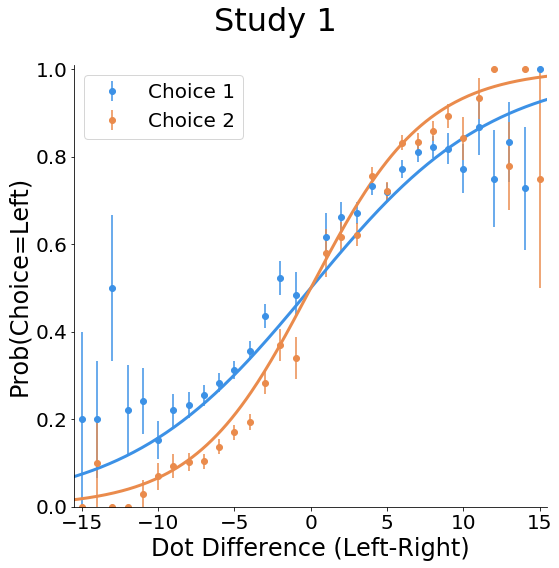

In [20]:
fig=figure(figsize=(8,8))
fig.suptitle('Study 1', fontsize = 32)
logistic_regression(subjects1, Data1)

<a id=Figure1C></a>

### Figure 1C

In [13]:
# make new dataframe for figure 1C
DF1=pd.DataFrame(data=[])
DF1['subject']=subjects1
DF1['ChosenTime']= [float(mean(Data1[Data1['Participant']==x]['ChosenTime']))/4 for x in DF1['subject']] # divide by total sampling time (4s)
DF1['UnchosenTime']=[float(mean(Data1[Data1['Participant']==x]['UnchosenTime']))/4 for x in DF1['subject']] # divide by total sampling time (4s)


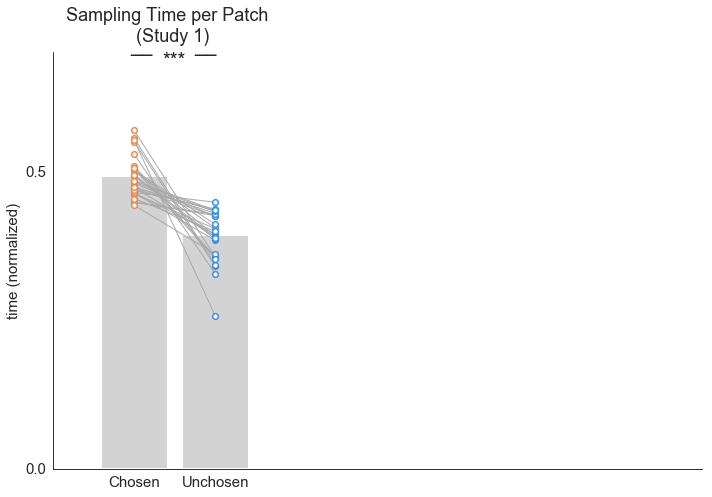

In [50]:
# make figure 1B
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF1['ChosenTime']), mean(DF1['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects1: # create points per participant and lines between them
    ax.scatter(0, DF1[DF1['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF1[DF1['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF1[DF1['subject']==subject]['ChosenTime'].iloc[0], DF1[DF1['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
#     ax.plot(1, DF1[DF1['subject']==subject]['UnchosenTime'], color='#A9A9A9', lw=1)
# set axes limits
ax.set_xlim([-1,7]) 
ax.set_ylim([-0.001,0.7])

# add some text for labels, title and axes ticks
ax.set_ylabel("time (normalized)", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 1)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(0.0, 0.7, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)
grid(False)
sns.set_style('white', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

ax.annotate('***', xy=(0.35,0.675), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,0.70), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,0.70), xycoords='data', fontsize=20)

sns.despine(right=True, top=True)
plt.tight_layout()

<a id=tACCStudy1></a>

### T-test Accuracy Study 1

In [14]:
DF1['Correct1']=[float(mean(Data1[Data1['Participant']==x]['Correct1'])) for x in DF1['subject']]
DF1['Correct2']=[float(mean(Data1[Data1['Participant']==x]['Correct2'])) for x in DF1['subject']]

In [15]:
sp.stats.ttest_rel(DF1['Correct1'],DF1['Correct2'])

Ttest_relResult(statistic=-8.741529860693433, pvalue=2.3407824744886355e-09)

<a id=tFigure1C></a>

### T-test Figure 1C

In [12]:
sp.stats.ttest_rel(DF1['ChosenTime'],DF1['UnchosenTime'])

Ttest_relResult(statistic=7.277405280948748, pvalue=7.923831501778047e-08)

<a id=Figure2A></a>

### Figure 2A

In [15]:
## bin confidence ratings
bins=np.linspace(-2,2,9)
Data1['Conf_bin']=pd.cut(Data1['ZConf1'],bins,labels=np.linspace(-1.75,1.75,8))

In [21]:
Data1.columns

Index(['Participant', 'Trial', 'Correct1', 'CorrectKey', 'Response1', 'RT1',
       'DotDifference', 'DotNumberRight', 'DotNumberLeft', 'Conf1', 'Conf1_RT',
       'CipResponse', 'CipRT', 'Correct2', 'Response2', 'RT2', 'Conf2',
       'Conf2_RT', 'ZConf1', 'ZConf2', 'Switch', 'ZSwitch', 'ZDifficult',
       'Block', 'NonAbsDiff', 'ZNonAbsDiff', 'LeftTime', 'RightTime',
       'ChosenTime', 'UnchosenTime', 'Change', 'Type', 'DeltaSampling',
       'ZDeltaSampling', 'ConfChange', 'Left1', 'Left2', 'Conf_bin'],
      dtype='object')

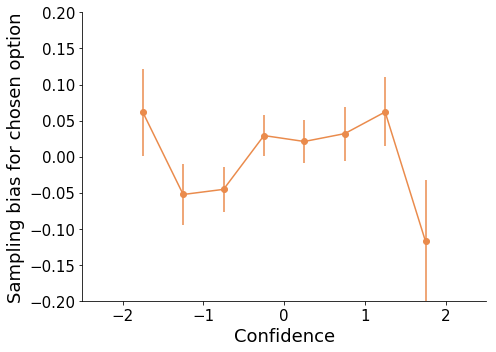

In [25]:
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
    #run the classifier
clf = sklearn.linear_model.LinearRegression()
logit1 = []
fig = figure(figsize=(7,5))
# fig.suptitle('Change of Mind and Sampling Bias', fontsize = 18)
plot = fig.add_subplot(1,1,1)
X_test = np.linspace(0,1,300)

mean_prob_choice = []
errors = []
bins = np.linspace(-1.75,1.75,8)
for y in bins:
    mean_prob_choice.append(mean(Data1[Data1['Conf_bin']==y]['ZDeltaSampling']))
    errors.append(stats.sem(Data1[Data1['Conf_bin']==y]['ZDeltaSampling']))
plot.errorbar(bins, mean_prob_choice, yerr=errors, fmt='-o', color='#EA8B4C')

plot.set_xlabel('Confidence', size=18)
plot.set_ylabel('Sampling bias for chosen option', size=18)
plot.set_xlim(-2.5, 2.5)
plot.set_ylim(-0.2, 0.2)
plot.tick_params(axis='both', which='major', labelsize=15)

#sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
plt.subplots_adjust(top=0.9, left=0.1)
plt.tight_layout()



<a id=Figure2B></a>

### Figure 2B

In [16]:
%%R
require("optimx")   ## for optim optimizers
require("nloptr")
nlminbw   <- lme4:::nlminbwrap

In [17]:
Data1.columns

Index(['Participant', 'Trial', 'Correct1', 'CorrectKey', 'Response1', 'RT1',
       'DotDifference', 'DotNumberRight', 'DotNumberLeft', 'Conf1', 'Conf1_RT',
       'CipResponse', 'CipRT', 'Correct2', 'Response2', 'RT2', 'Conf2',
       'Conf2_RT', 'ZConf1', 'ZConf2', 'Switch', 'ZSwitch', 'ZDifficult',
       'Block', 'NonAbsDiff', 'ZNonAbsDiff', 'LeftTime', 'RightTime',
       'ChosenTime', 'UnchosenTime', 'Change', 'Type', 'DeltaSampling',
       'ZDeltaSampling', 'ConfChange', 'Left1', 'Left2', 'Conf_bin'],
      dtype='object')

In [97]:
# create choice variable 0=right, 1=left
Data1['Choice']=[1 if x =='left' else 0 for x in Data1['Response1']]

In [18]:
# load data in R
# import new dataframe into R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Conf_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


In [19]:
# fit hierarchical regression model predicting sampling bias as a function of choice, dot difference and confidence rating
%R sampling_model1 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | Participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
%R print(summary(sampling_model1))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14159.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3463 -0.6178 -0.0116  0.6362  4.6527 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 Participant (Intercept)   0.0189544 0.13767                         
             Choice        0.0603223 0.24561  -0.96                  
             NonAbsDiff    0.0002879 0.01697  -0.22  0.18            
             ZConf1        0.0129680 0.11388   0.25 -0.40 -0.49      
             Choice:ZConf1 0.0207155 0.14393  -0.43  0.61  0.50 -0.89
 Residual                  0.7153908 0.84581                         
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
               Estim

In [20]:
%%R
# correct p-values (needed for hierarchical linear regressions)
df.KR <- get_ddf_Lb(sampling_model1, fixef(sampling_model1))
df.KR

[1] 26.95889


In [35]:
%%R
coefs <- data.frame(coef(summary(sampling_model1)))
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))
coefs

                 Estimate  Std..Error   t.value         p.KR
(Intercept)   -0.26801253 0.031592043 -8.483545 1.649555e-07
Choice         0.51152233 0.053052252  9.641859 2.679567e-08
NonAbsDiff     0.05190484 0.003984211 13.027632 2.903335e-10
ZConf1        -0.07975345 0.027700875 -2.879095 1.042777e-02
Choice:ZConf1  0.19047765 0.036230828  5.257336 6.457043e-05


In [64]:
# get subject-level coefficients from regression
%R coefs <- coef(sampling_model1)$Participant;
%R -o coefs

In [65]:
## add subject column
coefs['subject']=subjects1

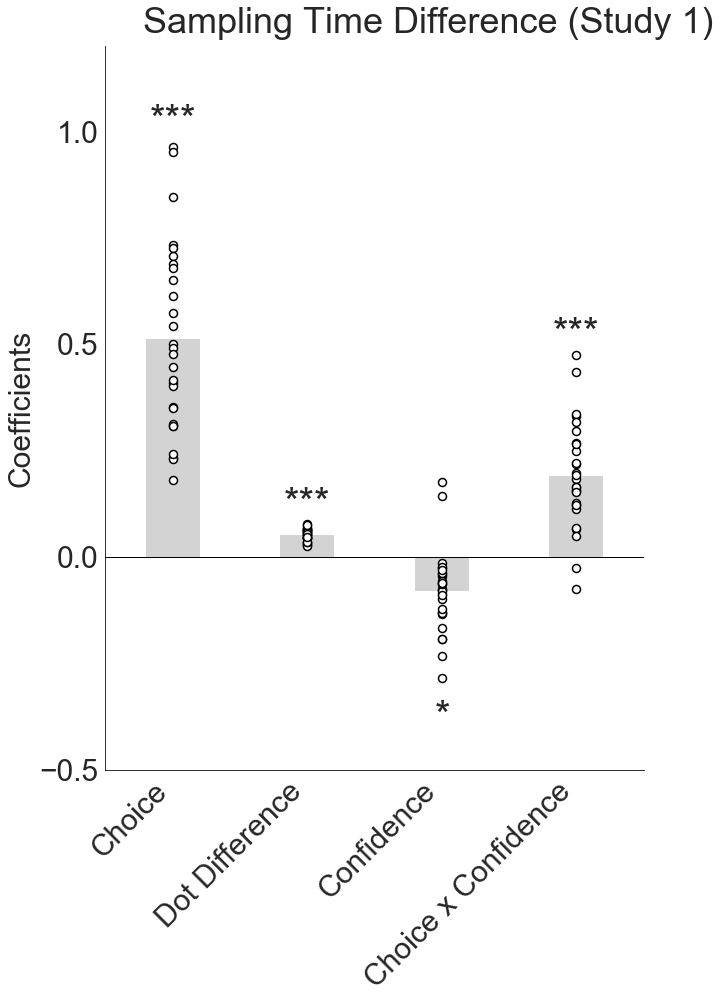

In [69]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2, 3]
y_mean = [mean(coefs['Choice']), mean(coefs['NonAbsDiff']), mean(coefs['ZConf1']), mean(coefs['Choice:ZConf1'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects1: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['Choice'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['NonAbsDiff'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(3, coefs[coefs['subject']==subject]['Choice:ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_xlim([-0.5,3.5])
ax.set_ylim([-0.5,1.2])

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Sampling Time Difference (Study 1)", fontsize=36)
ttl = ax.title
ttl.set_position([0.6, 1.01])
ax.set_xticks((np.arange(4)))
yticks = np.arange(-0.5, 1.2, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(("Choice", "Dot Difference", "Confidence", "Choice x Confidence"), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('***', xy=(0,1), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(1,0.1), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('*', xy=(2.005,-0.4), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(3,0.5), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()
plt.savefig('Fig2B.pdf')

<a id=Figure2C></a>

<a id=Figure2C></a>

### Figure 2C

In [164]:
## define sampling bias as chosen-unchosen time
Data1['SamplingBias']=Data1['ChosenTime']-Data1['UnchosenTime']

In [108]:
# create new index for z-scoring
new_index=range(len(Data1))
Data1['index']=new_index
Data1['participant']=Data1['Participant'] # create copy of participant column
Data1 = Data1.set_index(['Participant', 'index'])

In [165]:
## z-score sampling bias
Data1.head()
Data1['ZBias'] = (Data1['SamplingBias']-Data1.groupby(level='Participant')['SamplingBias'].mean())/Data1.groupby(level = 'Participant')['SamplingBias'].std()
# Are the mean Z-scores all close to 0?
Data1.groupby(level=0)['ZBias'].mean()


Participant
1    -6.772360e-17
2     2.420286e-16
3    -3.619327e-16
4    -2.664535e-17
5     1.110223e-18
6     1.060263e-16
7    -1.432188e-16
8     3.139156e-16
9     2.686740e-16
10   -3.552714e-17
11    6.439294e-17
12   -8.326673e-17
13    3.663736e-17
14   -9.436896e-17
16    2.817191e-16
17   -6.800116e-17
18    8.104628e-17
19    2.914335e-17
20   -3.871903e-17
21   -2.645106e-16
22    6.428191e-16
23    1.282308e-16
24    1.193490e-17
25   -2.109077e-16
26   -3.405609e-16
27   -2.386980e-16
29    1.765255e-16
30    5.939693e-17
Name: ZBias, dtype: float64

In [159]:
# square dot difference (fewer convergence issues)
Data1['DDsqrt']=sqrt(Data1['DotDifference'])

In [73]:
# load data into R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df
%R r_df['Change']=r_df['Change'][,1]

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Conf_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


array([1, 1, 0, ..., 0, 0, 1], dtype=int32)

In [74]:
# fit logistic regression model predicting change of mind as a function of dot difference, sampling bias and confidence
%R changemodel1 = glmer(Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
%R print(summary(changemodel1))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 |  
    participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4668.0   4760.8  -2320.0   4640.0     5586 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9698 -0.4983 -0.2696 -0.0795 10.4281 

Random effects:
 Groups      Name        Variance Std.Dev. Corr             
 participant (Intercept) 0.311488 0.5581                    
             DDsqrt      0.001005 0.0317   -1.00            
             ZBias       0.284694 0.5336    0.02 -0.02      
             ZConf1      0.046305 0.2152    0.45 -0.45 -0.16
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.17566    0.20793  -5.654 1.57e-08 ***
DDsqrt      -0.2396

In [99]:
# get subject-level coefficients from regression
%R coefs <- coef(changemodel1)$participant;
%R -o coefs

In [100]:
## add subject column
coefs['subject']=subjects1

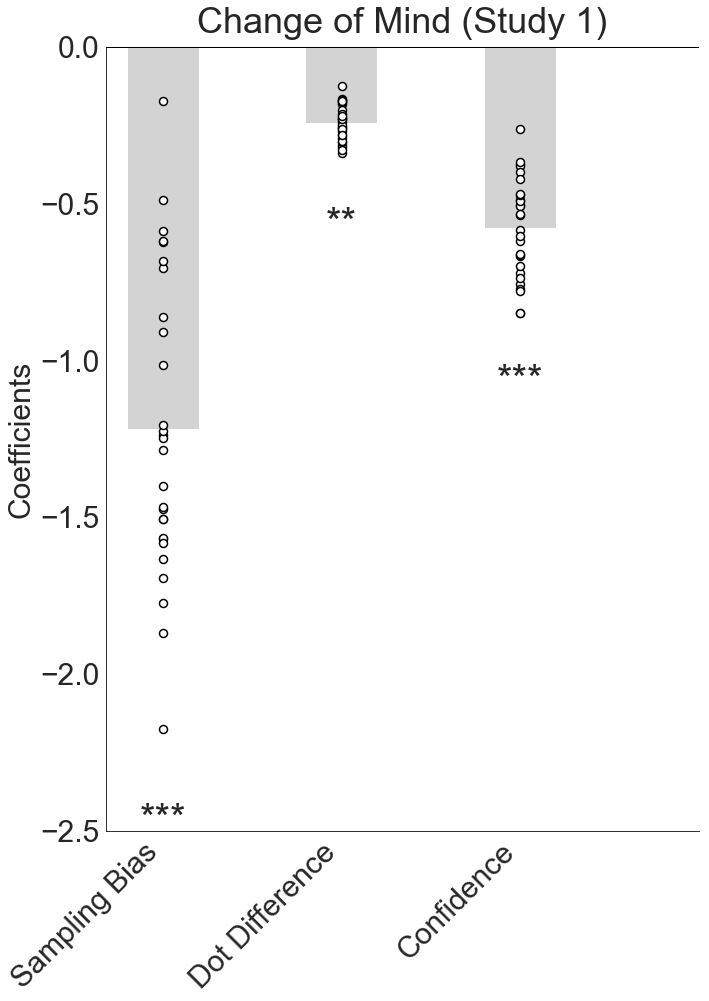

In [103]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2]
y_mean = [mean(coefs['ZBias']), mean(coefs['DDsqrt']), mean(coefs['ZConf1'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects1: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['ZBias'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['DDsqrt'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Change of Mind (Study 1)", fontsize=36)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(4)))
yticks = np.arange(-2.5, 0.5, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(('Sampling Bias', 'Dot Difference', 'Confidence'), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('***', xy=(0,-2.5), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('**', xy=(1,-0.6), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(2,-1.1), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()


<a id=Figure3B></a>

### Figure 3B

In [39]:
# make new dummy variable encoding whether or not a left response was made for both choices
Data2['Left1'] = [1 if x == 'left' else 0 for x in Data2['Response1']]
Data2['Left2'] = [1 if x == 'left' else 0 for x in Data2['Response2']]

In [127]:
Data2.columns

Index(['participant', 'Trial', 'Block', 'RT1', 'RT2', 'Conf1', 'Conf2',
       'Correct1', 'Correct2', 'Conf1_RT', 'Conf2_RT', 'DotNumberLeft',
       'DotNumberRight', 'DotDifference', 'Switch', 'Left_Presentation_Time',
       'Right_Presentation_Time', 'LeftTime', 'RightTime', 'NonAbsDiff',
       'Response1', 'Response2', 'ZConf1', 'ZConf2', 'Zdifficult',
       'ZNonAbsDiff', 'SamplingLength', 'Session', 'Type', 'ZSwitch',
       'DeltaSampling', 'ZDeltaSampling', 'ChosenTime', 'UnchosenTime',
       'Chosen_Presentation_Time', 'Unchosen_Presentation_Time', 'ConfChange',
       'Left_IA_First_Dwell_Time', 'Right_IA_First_Dwell_Time',
       'LeftTime_First', 'RightTime_First', 'Left1', 'Left2'],
      dtype='object')

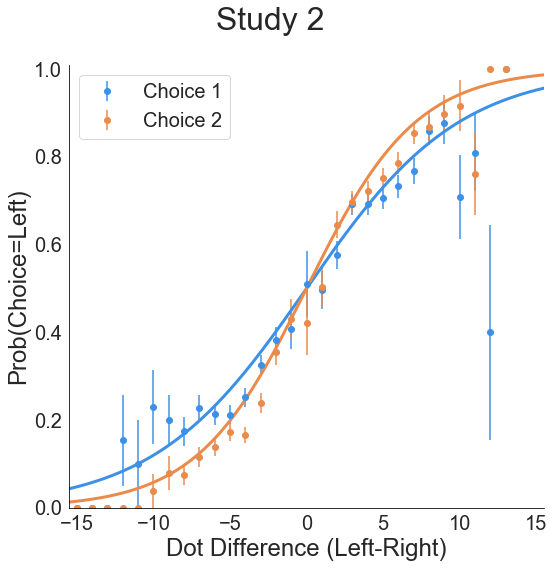

In [47]:
fig=figure(figsize=(8,8))
fig.suptitle('Study 2', fontsize = 32)
logistic_regression(subjects2, Data2)
plt.savefig('Fig3B.pdf')

<a id=Figure3C></a>

### Figure 3C

In [48]:
# calculate proportion of sampling time spent on chosen and unchosen options
Data2Free['ChosenPercTime'] = Data2Free['ChosenTime']/Data2Free['SamplingLength']
Data2Free['UnchosenPercTime'] = Data2Free['UnchosenTime']/Data2Free['SamplingLength']

In [49]:
# make new dataframe for figure 1C
DF2=pd.DataFrame(data=[])
DF2['subject']=subjects2
DF2['ChosenTime']= [float(mean(Data2Free[Data2Free['participant']==x]['ChosenPercTime'])) for x in DF2['subject']]
DF2['UnchosenTime']=[float(mean(Data2Free[Data2Free['participant']==x]['UnchosenPercTime'])) for x in DF2['subject']]



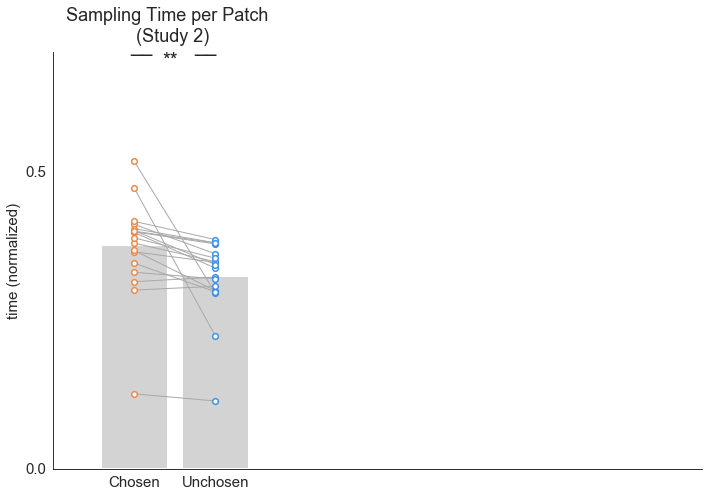

In [50]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF2['ChosenTime']), mean(DF2['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[DF2['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[DF2['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF2[DF2['subject']==subject]['ChosenTime'].iloc[0], DF2[DF2['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,7])
ax.set_ylim([-0.001,0.7])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time (normalized)", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 2)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(0, 0.7, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)
#ax.set_axis_bgcolor('white')

#sns.set_style('white', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

ax.annotate('**', xy=(0.35,0.675), xycoords='data', fontsize=20)
            #xy=(0, 1), xycoords='data',
            #xytext=(-50, 30), textcoords='offset points',
            #arrowprops=dict(arrowstyle="->"))
            
ax.annotate('__', xy=(-0.05,0.70), xycoords='data', fontsize=20)
            #xy=(0, 1), xycoords='data',
            #xytext=(-50, 30), textcoords='offset points',
            #arrowprops=dict(arrowstyle="->"))
            
ax.annotate('__', xy=(0.745,0.70), xycoords='data', fontsize=20)
            #xy=(0, 1), xycoords='data',
            #xytext=(-50, 30), textcoords='offset points',
            #arrowprops=dict(arrowstyle="->"))

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()


<a id=tACCStudy2></a>

### T-test Accuracy Study 2

In [21]:
DF2['Correct1']=[float(mean(Data2[Data2['participant']==x]['Correct1'])) for x in DF2['subject']]
DF2['Correct2']=[float(mean(Data2[Data2['participant']==x]['Correct2'])) for x in DF2['subject']]

In [149]:
sp.stats.ttest_rel(DF2['Correct1'],DF2['Correct2'])

Ttest_relResult(statistic=-7.140839930733507, pvalue=1.6535371024436757e-06)

<a id=tFigure3C></a>

### T-test Figure 3C

In [150]:
sp.stats.ttest_rel(DF2['ChosenTime'],DF2['UnchosenTime'])

Ttest_relResult(statistic=3.1642762349979305, pvalue=0.0056665252371096144)

<a id=Figure4A></a>

### Figure 4A

In [51]:
bins=np.linspace(-2,2,9)
Data2Free['Conf_bin']=pd.cut(Data2Free['ZConf1'],bins,labels=np.linspace(-1.75,1.75,8))

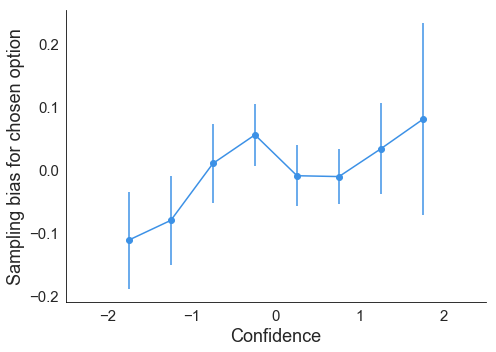

In [52]:
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
    #run the classifier
clf = sklearn.linear_model.LinearRegression()
logit1 = []
fig = figure(figsize=(7,5))
# fig.suptitle('Change of Mind and Sampling Bias', fontsize = 18)
plot = fig.add_subplot(1,1,1)
X_test = np.linspace(0,1,300)

# plot study 1
mean_prob_choice = []
errors = []
bins = np.linspace(-1.75,1.75,8)
for y in bins:
    mean_prob_choice.append(mean(Data2Free[Data2Free['Conf_bin']==y]['ZDeltaSampling']))
    errors.append(stats.sem(Data2Free[Data2Free['Conf_bin']==y]['ZDeltaSampling']))
plot.errorbar(bins, mean_prob_choice, yerr=errors, fmt='-o', color='#3C91E6')

plot.set_xlabel('Confidence', size=18)
plot.set_ylabel('Sampling bias for chosen option', size=18)
plot.set_xlim(-2.5, 2.5)
plot.tick_params(axis='both', which='major', labelsize=15)

#sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
# plot.legend(loc=2, prop={'size':18})
sns.despine(right=True, top=True)
plt.subplots_adjust(top=0.9, left=0.1)
plt.tight_layout()
plt.savefig('Fig4A.pdf')

<a id=Figure4B></a>

### Figure 4B

In [223]:
%%R
require("optimx")   ## for optim optimizers
require("nloptr")
nlminbw   <- lme4:::nlminbwrap

In [132]:
Data2Free['Choice']=[1 if x == 'left' else 0 for x in Data2Free['Response1']]

In [55]:
# load data in R
# import new dataframe into R
r_df = pandas2ri.py2ri(Data2Free)
%R -i r_df

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "Conf_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


In [56]:
%%R
# fit hierarchical regression model predicting sampling bias as a function of choice, dot difference and confidence rating
sampling_model2 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer ='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6012.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4947 -0.5902 -0.0023  0.6129  4.2636 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 participant (Intercept)   4.415e-02 0.210112                        
             Choice        1.629e-01 0.403625 -1.00                  
             NonAbsDiff    2.982e-05 0.005461 -0.18  0.13            
             ZConf1        1.073e-02 0.103594  0.54 -0.59  0.73      
             Choice:ZConf1 1.360e-02 0.116604 -0.92  0.94 -0.22 -0.83
 Residual                  8.276e-01 0.909709                        
Number of obs: 2244, groups:  participant, 18

Fixed effects:
               Estima

In [57]:
%%R
# correct coefficients & p-value
df.KR <- get_ddf_Lb(sampling_model2, fixef(sampling_model2))
df.KR

[1] 16.96893


In [59]:
%%R
coefs <- data.frame(coef(summary(sampling_model2)))
coefs$p.KR <- 2 * (1 - pt(abs(coefs$t.value), df.KR))
coefs

                 Estimate  Std..Error   t.value         p.KR
(Intercept)   -0.14998741 0.057098725 -2.626808 1.768996e-02
Choice         0.30326534 0.104568577  2.900157 9.973125e-03
NonAbsDiff     0.04387825 0.004763963  9.210453 5.177037e-08
ZConf1        -0.09015311 0.037076860 -2.431520 2.640851e-02
Choice:ZConf1  0.21342255 0.049751068  4.289809 4.976109e-04


In [60]:
# grab subject-level coefficients
%R coefs <- coef(sampling_model2)$participant
%R -o coefs

In [61]:
# index coefficient dataframe
coefs['subject']=subjects2

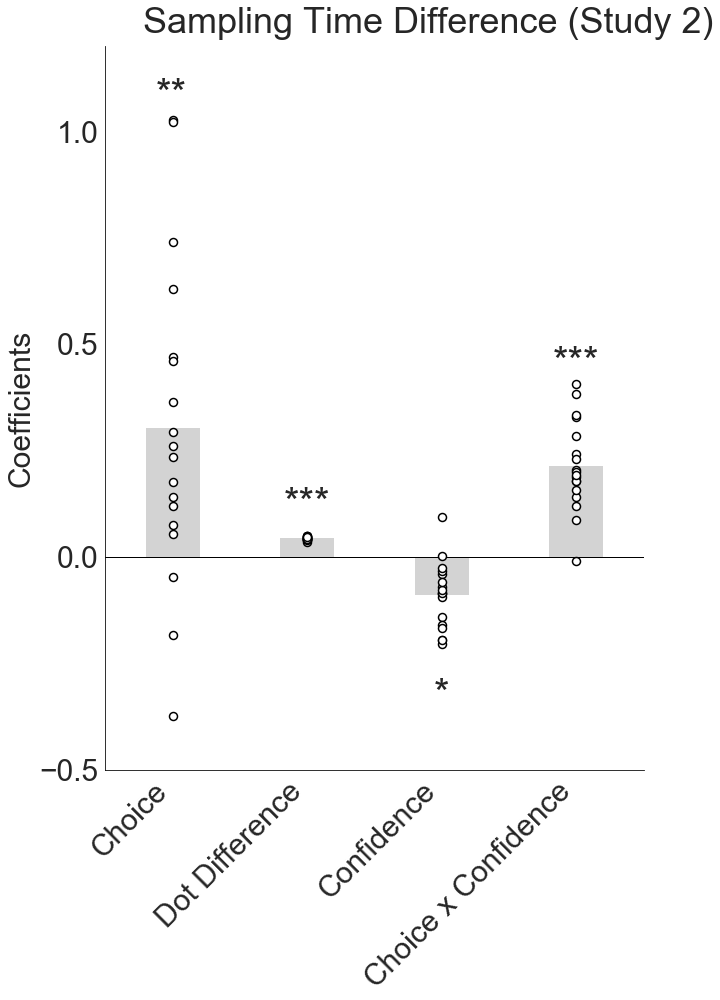

In [62]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2, 3]
y_mean = [mean(coefs['Choice']), mean(coefs['NonAbsDiff']), mean(coefs['ZConf1']), mean(coefs['Choice:ZConf1'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects2: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['Choice'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['NonAbsDiff'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(3, coefs[coefs['subject']==subject]['Choice:ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_xlim([-0.5,3.5])
ax.set_ylim([-0.5,1.2])

# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Sampling Time Difference (Study 2)", fontsize=36)
ttl = ax.title
ttl.set_position([0.6, 1.01])
ax.set_xticks((np.arange(4)))
yticks = np.arange(-0.5, 1.2, 0.5)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(("Choice", "Dot Difference", "Confidence", "Choice x Confidence"), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('**', xy=(-0.01,1.06), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(1,0.1), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('*', xy=(2,-0.35), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(3,0.43), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()
plt.savefig('Fig4B.pdf')

<a id=Figure4C></a>

### Figure 4C

In [209]:
## define sampling bias as chosen-unchosen time
Data2['SamplingBias']=Data2['ChosenTime']-Data2['UnchosenTime']

In [210]:
# re-index for z-scoring
Data2.reset_index(inplace=True)
Data2.index = range(1, len(Data2) + 1)
Data2['Participant']=Data2['participant']
Data2 = Data2.set_index(['Participant', 'index'])

In [211]:
# Z-score new bias variable 
Data2.head()
Data2['ZBias'] = (Data2['SamplingBias']-Data2.groupby(level='Participant')['SamplingBias'].mean())/Data2.groupby(level = 'Participant')['SamplingBias'].std()
# Are the mean Z-scores all close to 0?
Data2.groupby(level=0)['ZBias'].mean()

Participant
1    -1.546382e-16
2    -1.441963e-16
7    -6.265159e-17
9    -2.244677e-16
10    3.788856e-17
11   -2.643388e-18
13    1.950600e-16
14    4.141308e-17
15   -2.819614e-17
17    2.643388e-18
18   -1.186136e-19
19   -4.053195e-17
20   -7.220963e-18
21   -2.202823e-17
22   -1.503427e-17
24    1.251204e-16
25    1.497920e-17
26    1.127846e-16
Name: ZBias, dtype: float64

In [212]:
# square dot difference (fewer convergence issues)
Data2['DDsqrt']=sqrt(Data2['DotDifference'])

In [213]:
# create variable for free vs fixed viewing session (0=free; 1=fixed)
Data2['FixedSampling']=[1 if x == 'Fixed' else 0 for x in Data2['Session']]

In [214]:
# create variable for change of mind (0=no change; 1=change)
Data2['change']=0
Data2.loc[Data2['Response1']!=Data2['Response2'], 'change']=1

In [32]:
# load data into R
r_df = pandas2ri.py2ri(Data2)
%R -i r_df

In [33]:
%%R
changemodel2 <- glmer(change ~ ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling*ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling*ZBias | participant), data=r_df, control = lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminbw", starttests = FALSE, kkt = FALSE)), family="binomial")
print(summary(changemodel2))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  
    ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  
    ZBias | participant)
   Data: r_df
Control: 
lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminbw",  
    starttests = FALSE, kkt = FALSE))

     AIC      BIC   logLik deviance df.resid 
  4080.5   4253.6  -2013.3   4026.5     4473 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5424 -0.4985 -0.3538 -0.1898  5.2785 

Random effects:
 Groups      Name                Variance Std.Dev. Corr                   
 participant (Intercept)         0.83766  0.9152                          
             ZBias               0.43421  0.6589    0.45                  
             DDsqrt              0.04157  0.2039   -0.99 -0.33            
             ZConf1            

In [70]:
# grab subject-level coefficients
%R coefs <- coef(changemodel2)$participant
%R -o coefs

In [71]:
# index coefficient dataframe
coefs['subject']=subjects2

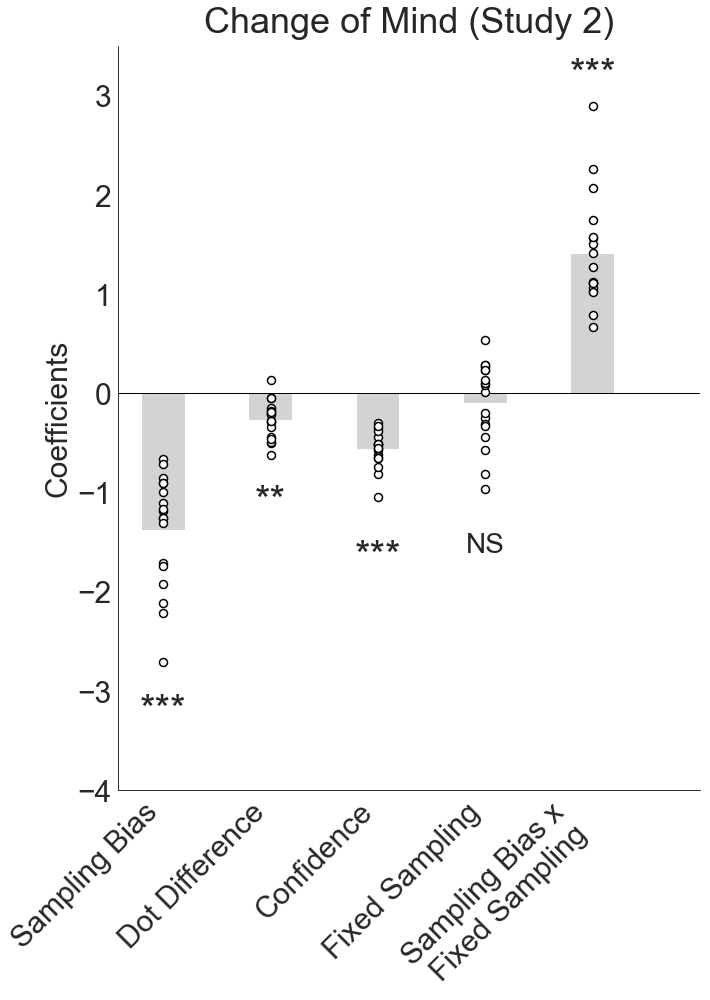

In [72]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 14)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1, 2, 3, 4]
y_mean = [mean(coefs['ZBias']), mean(coefs['DDsqrt']), mean(coefs['ZConf1']), mean(coefs['FixedSampling']), mean(coefs['ZBias:FixedSampling'])]

ax.bar(x_mean, y_mean, width=0.4, align='center', color='lightgray', edgecolor='none') # create bar graph
for subject in subjects2: # create scatter
    ax.scatter(0, coefs[coefs['subject']==subject]['ZBias'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(1, coefs[coefs['subject']==subject]['DDsqrt'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(2, coefs[coefs['subject']==subject]['ZConf1'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(3, coefs[coefs['subject']==subject]['FixedSampling'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)
    ax.scatter(4, coefs[coefs['subject']==subject]['ZBias:FixedSampling'].iloc[0], zorder=10, marker='o', s=64, color='white', edgecolor='black', lw=1.5)

# set axes limits
ax.set_ylim([-4,3.5])
    
# add some text for labels, title and axes ticks
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
grid(False)
sns.despine(right=True, top=True)
ax.set_ylabel("Coefficients", fontsize=30)
ax.set_title("Change of Mind (Study 2)", fontsize=36)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
yticks = np.arange(-4, 4, 1)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=30)
ax.set_xticklabels(('Sampling Bias', 'Dot Difference', 'Confidence', 'Fixed Sampling', 'Sampling Bias x\nFixed Sampling'), rotation=45, ha='right', fontsize=30)
#ax.set_axis_bgcolor('white')

pylab.axhline(y=0.0, linewidth=1, color = 'k')

ax.annotate('***', xy=(0,-3.3), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('**', xy=(1,-1.2), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('***', xy=(2,-1.75), xycoords='data', fontsize=40, ha='center')
            
ax.annotate('NS', xy=(3,-1.6), xycoords='data', fontsize=28, ha='center')

ax.annotate('***', xy=(4,3.1), xycoords='data', fontsize=40, ha='center')
            
plt.tight_layout()
plt.savefig('Fig4C.pdf')

<a id=Figure4D></a>

### Figure 4D

In [77]:
# create variables describing proportion of total sampling time spent on each patch
Data2Free['ChosenPercTime']=Data2Free['ChosenTime']/Data2Free['SamplingLength']
Data2Free['UnchosenPercTime']=Data2Free['UnchosenTime']/Data2Free['SamplingLength']
Data2Fixed['ChosenPercTime']=Data2Fixed['ChosenTime']/(Data2Fixed['LeftTime']+Data2Fixed['RightTime'])
Data2Fixed['UnchosenPercTime']=Data2Fixed['UnchosenTime']/(Data2Fixed['LeftTime']+Data2Fixed['RightTime'])



In [78]:
bins = np.linspace(0.175,0.625,10)
Data2Free['new_bias_bin']=pd.cut(Data2Free['ChosenPercTime'], bins, labels=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6])
Data2Fixed['new_bias_bin']=pd.cut(Data2Fixed['ChosenPercTime'], bins, labels=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6])


In [79]:
# create variable for change of mind (0=no change; 1=change)
Data2Free['change']=0
Data2Free.loc[Data2Free['Response1']!=Data2Free['Response2'], 'change']=1
Data2Fixed['change']=0
Data2Fixed.loc[Data2Fixed['Response1']!=Data2Fixed['Response2'], 'change']=1

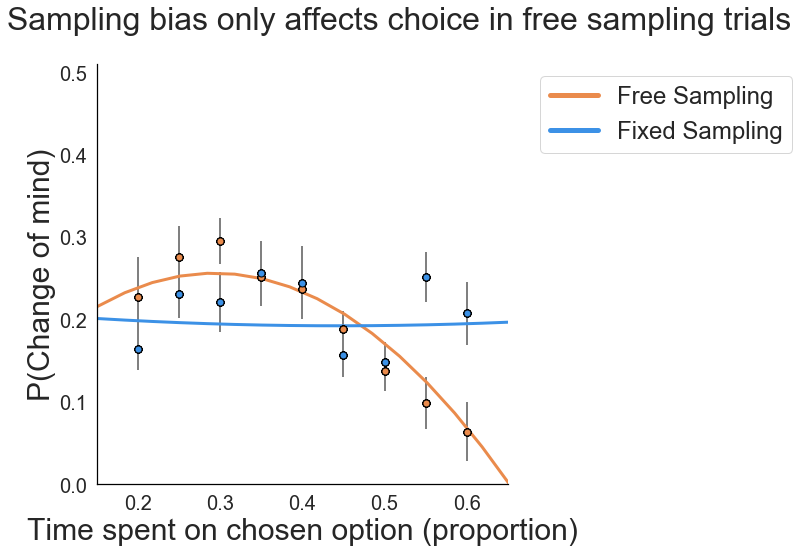

In [137]:
sns.set(font_scale=2)
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
fig=figure(figsize=(12,8))
fig.suptitle('Sampling bias only affects choice in free sampling trials', fontsize = 32)
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
#run the classifier
clf = sklearn.linear_model.LogisticRegression(C=1e5)
logit1 = []
logit2 = []
plot = fig.add_subplot(1,1,1)
#plot the data
#plt.clf()
colors=['#540D6E', '#46B1C9', '#F5EE9E', '#EAF9D9', '#B5E2FA', '#A5B452', '#CCC7B9', '#DB324D']

mean_prob_free=[]
var_prob_free=[]
mean_prob_fixed=[]
var_prob_fixed=[]
rankdiffs=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
rankdiffs2=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
for y in rankdiffs:
    mean_prob_free.append(mean(Data2Free[Data2Free['new_bias_bin']==y]['change']))
    var_prob_free.append(sp.stats.sem(Data2Free[Data2Free['new_bias_bin']==y]['change']))
for y in rankdiffs2:
    mean_prob_fixed.append(mean(Data2Fixed[Data2Fixed['new_bias_bin']==y]['change']))
    var_prob_fixed.append(sp.stats.sem(Data2Fixed[Data2Fixed['new_bias_bin']==y]['change']))

X_test = np.linspace(-5,5,300)

coefs_free = np.polyfit(Data2Free['ChosenPercTime'].values,  Data2Free['change'].values.flatten(), 2)
coefs_fixed = np.polyfit(Data2Fixed['ChosenPercTime'].values,  Data2Fixed['change'].values.flatten(), 2)

plot.plot(X_test, np.polyval(coefs_free, X_test), linewidth=3, color='#EA8B4C')
plot.plot(X_test, np.polyval(coefs_fixed, X_test), linewidth=3, color='#3C91E6')

for y in rankdiffs:
    plot.errorbar(rankdiffs, mean_prob_free, yerr=var_prob_free, fmt = 'o', marker='o',markerfacecolor='#EA8B4C', markeredgecolor = 'black', ms = 7, ecolor='gray')
    plot.errorbar(rankdiffs2, mean_prob_fixed, yerr=var_prob_fixed, fmt = 'o', marker='o',markerfacecolor='#3C91E6', markeredgecolor = 'black', ms = 7, ecolor='gray')

plot.set_ylabel('P(Change of mind)', size=30)
plot.set_xlabel('Time spent on chosen option (proportion)', size=30)
plot.tick_params(axis='both', which='major', labelsize=20)

plot.set_ylim(0, 0.51)
plot.set_xlim(0.15, 0.65)
plot.grid(True)
grid(False)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#EA8B4C', lw=5),
                Line2D([0], [0], color='#3C91E6', lw=5)]

plot.legend(custom_lines, ['Free Sampling', 'Fixed Sampling'], prop={'size': 24}, bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine(right=True, top=True)
plt.tight_layout()
plt.subplots_adjust(top=0.88, left=0.15)


<a id=Saccades></a>

### Saccades

In [160]:
# make new dataframe for t-test
DF3=pd.DataFrame(data=[])
DF3['subject']=subjects2
DF3['FreeSaccades']= [float(mean(Data2Free[Data2Free['participant']==x]['Internal_Saccades'])) for x in DF3['subject']]
DF3['FixedSaccades']=[float(mean(Data2Fixed[Data2Fixed['participant']==x]['Internal_Saccades'])) for x in DF3['subject']]


In [161]:
# test if there were more 
sp.stats.ttest_rel(DF3['FreeSaccades'],DF3['FixedSaccades'])

Ttest_relResult(statistic=-4.221057153034456, pvalue=0.0005749020430666255)

<a id=FigureS3_1></a>

### Figure S3.1

#### 3000ms sampling time

In [64]:
# load excluded short sampling trials from free sampling condition
Data2_short_samp=pd.read_csv('../data/short_sampling_trials.csv')

In [65]:
# sampling time variable for chosen and unchosen patch
Data2_short_samp['Chosen-Time'] = [Data2_short_samp['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_short_samp['PICKED_LEFT_1'].iloc[row]==True else Data2_short_samp['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_short_samp))]
Data2_short_samp['Unchosen-Time'] = [Data2_short_samp['Left_IA_Second_Dwell_Time'].iloc[row] if Data2_short_samp['PICKED_LEFT_1'].iloc[row]==False else Data2_short_samp['Right_IA_Second_Dwell_Time'].iloc[row] for row in range(len(Data2_short_samp))]


In [66]:
# make new dataframe for figure
DF2=pd.DataFrame(data=[])
DF2['subject']=subjects2
DF2['ChosenTime']= [float(mean(Data2_short_samp[Data2_short_samp['Participant']==x]['Chosen-Time'])) for x in DF2['subject']]
DF2['UnchosenTime']=[float(mean(Data2_short_samp[Data2_short_samp['Participant']==x]['Unchosen-Time'])) for x in DF2['subject']]



In [67]:
# do t-test
sp.stats.ttest_rel(DF2['ChosenTime'],DF2['UnchosenTime'])

Ttest_relResult(statistic=2.928524646579678, pvalue=0.009377648461370625)

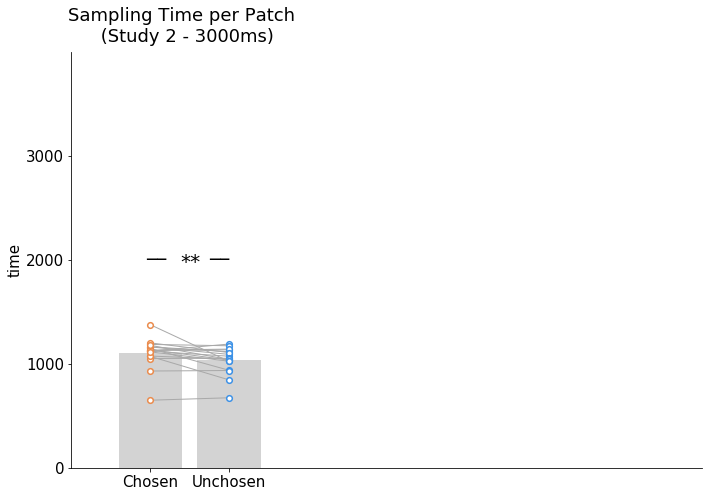

In [68]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF2['ChosenTime']), mean(DF2['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[DF2['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[DF2['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF2[DF2['subject']==subject]['ChosenTime'].iloc[0], DF2[DF2['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,7])
ax.set_ylim([-0.001,4000])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 2 - 3000ms)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
yticks = np.arange(0, 4000, 1000)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)


ax.annotate('**', xy=(0.38,1920), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,2050), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,2050), xycoords='data', fontsize=20)

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('sampling_study2_3000.pdf')


#### 5000ms sampling time

In [69]:
Data2_med_samp = Data2Free[Data2Free['SamplingLength']==5]

In [70]:
# make new dataframe for figure
DF2=pd.DataFrame(data=[])
DF2['subject']=subjects2
DF2['ChosenTime']= [float(mean(Data2_med_samp[Data2_med_samp['participant']==x]['ChosenTime']))*1000 for x in DF2['subject']]
DF2['UnchosenTime']=[float(mean(Data2_med_samp[Data2_med_samp['participant']==x]['UnchosenTime']))*1000 for x in DF2['subject']]



In [71]:
# do t-test
sp.stats.ttest_rel(DF2['ChosenTime'],DF2['UnchosenTime'])

Ttest_relResult(statistic=3.496837482071987, pvalue=0.0027629243103997132)

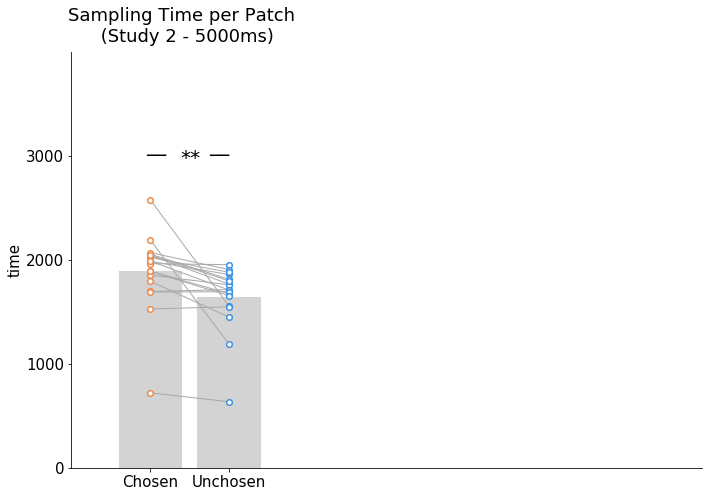

In [72]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF2['ChosenTime']), mean(DF2['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[DF2['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[DF2['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF2[DF2['subject']==subject]['ChosenTime'].iloc[0], DF2[DF2['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,7])
ax.set_ylim([-0.001,4000])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 2 - 5000ms)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
ax.set_xticks((np.arange(2)))
yticks = np.arange(0, 4000, 1000)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)

ax.annotate('**', xy=(0.38,2920), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,3050), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,3050), xycoords='data', fontsize=20)

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('sampling_study2_5000.pdf')


#### 7000ms sampling time

In [73]:
Data2_long_samp = Data2Free[Data2Free['SamplingLength']==7]

In [74]:
# make new dataframe for figure
DF2=pd.DataFrame(data=[])
DF2['subject']=subjects2
DF2['ChosenTime']= [float(mean(Data2_long_samp[Data2_long_samp['participant']==x]['ChosenTime']))*1000 for x in DF2['subject']]
DF2['UnchosenTime']=[float(mean(Data2_long_samp[Data2_long_samp['participant']==x]['UnchosenTime']))*1000 for x in DF2['subject']]



In [75]:
# do t-test
sp.stats.ttest_rel(DF2['ChosenTime'],DF2['UnchosenTime'])

Ttest_relResult(statistic=2.860693156029368, pvalue=0.010826840008252105)

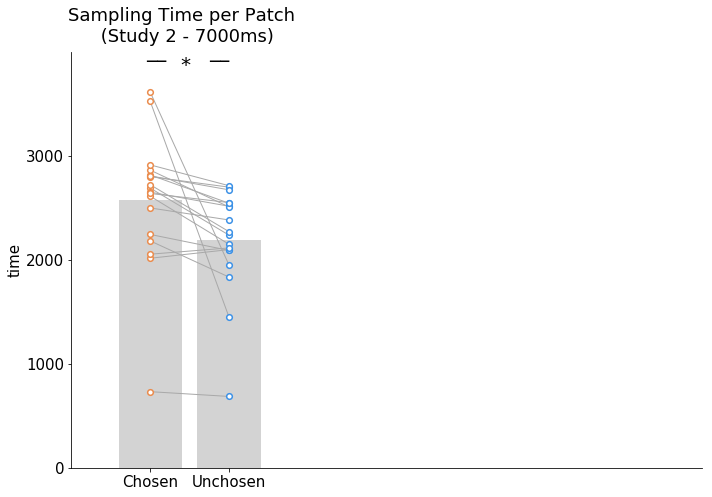

In [76]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

x_mean = [0, 1]
y_mean = [mean(DF2['ChosenTime']), mean(DF2['UnchosenTime'])]

ax.bar(x_mean, y_mean, align='center', color='lightgray', edgecolor='none') #create bar graph
for subject in subjects2: # create points per participant and lines between them
    ax.scatter(0, DF2[DF2['subject']==subject]['ChosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#EA8B4C', lw=1.5)
    ax.scatter(1, DF2[DF2['subject']==subject]['UnchosenTime'], zorder=10, marker='o', s=32, color='white', edgecolor='#3C91E6', lw=1.5)
    x = [0, 1]
    y = [DF2[DF2['subject']==subject]['ChosenTime'].iloc[0], DF2[DF2['subject']==subject]['UnchosenTime'].iloc[0]]
    ax.plot(x, y, color='#A9A9A9', lw=1)
# set axes limits    
ax.set_xlim([-1,7])
ax.set_ylim([-0.001,4000])
    
    
# add some text for labels, title and axes ticks
ax.set_ylabel("time", fontsize=15)
ax.set_title("Sampling Time per Patch \n (Study 2 - 7000ms)", fontsize=18)
ttl = ax.title
ttl.set_position([0.18, 1.01])
ax.set_xticks((np.arange(2)))
ax.set_xticks((np.arange(2)))
yticks = np.arange(0, 4000, 1000)
ax.set_yticks(yticks)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Chosen", "Unchosen"), fontsize=15)

ax.annotate('*', xy=(0.38,3820), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(-0.05,3950), xycoords='data', fontsize=20)
            
ax.annotate('__', xy=(0.745,3950), xycoords='data', fontsize=20)

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('sampling_study2_7000.pdf')


<a id=FigureS4_1></a>

### Figure S4.1

In [90]:
# get variables describing presentation time for chosen and unchosen patches as proportion of total time in fixed sampling condition
Data2Fixed['ChosenPercPersTime']=Data2Fixed['Chosen_Presentation_Time']/(Data2Fixed['Left_Presentation_Time']+Data2Fixed['Right_Presentation_Time'])
Data2Fixed['UnchosenPercPersTime']=Data2Fixed['Unchosen_Presentation_Time']/(Data2Fixed['Left_Presentation_Time']+Data2Fixed['Right_Presentation_Time'])


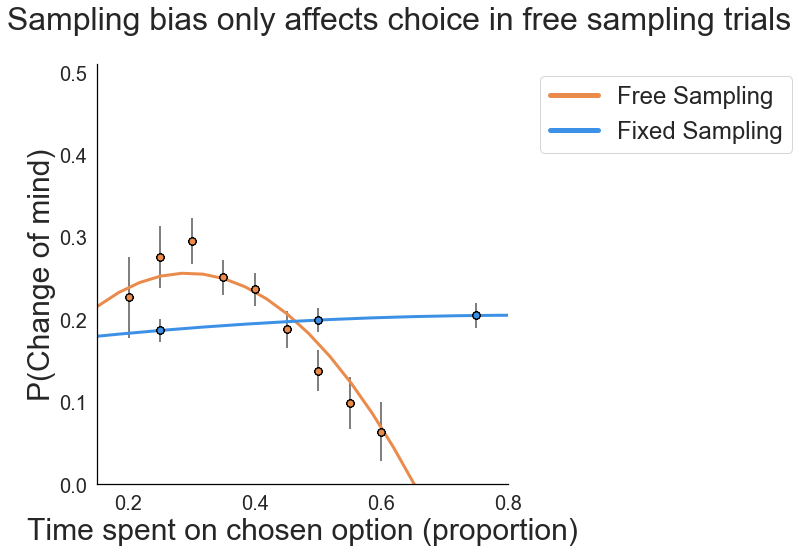

In [93]:
sns.set(font_scale=2)
sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})
fig=figure(figsize=(12,8))
fig.suptitle('Sampling bias only affects choice in free sampling trials', fontsize = 32)
def model(x):
    y = 1 / (1 + np.exp(-x))
    return y
#run the classifier
clf = sklearn.linear_model.LogisticRegression(C=1e5)
logit1 = []
logit2 = []
plot = fig.add_subplot(1,1,1)
#plot the data
#plt.clf()
colors=['#540D6E', '#46B1C9', '#F5EE9E', '#EAF9D9', '#B5E2FA', '#A5B452', '#CCC7B9', '#DB324D']

mean_prob_free=[]
var_prob_free=[]
mean_prob_fixed=[]
var_prob_fixed=[]
rankdiffs=[0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]
rankdiffs2=[0.25, 0.5, 0.75]
for y in rankdiffs:
    mean_prob_free.append(mean(Data2Free[Data2Free['new_bias_bin']==y]['change']))
    var_prob_free.append(sp.stats.sem(Data2Free[Data2Free['new_bias_bin']==y]['change']))
for y in rankdiffs2:
    mean_prob_fixed.append(mean(Data2Fixed[Data2Fixed['ChosenPercPersTime']==y]['change']))
    var_prob_fixed.append(sp.stats.sem(Data2Fixed[Data2Fixed['ChosenPercPersTime']==y]['change']))

X_test = np.linspace(-5,5,300)

coefs_free = np.polyfit(Data2Free['ChosenPercTime'].values,  Data2Free['change'].values.flatten(), 2)
coefs_fixed = np.polyfit(Data2Fixed['ChosenPercPersTime'].values,  Data2Fixed['change'].values.flatten(), 2)

plot.plot(X_test, np.polyval(coefs_free, X_test), linewidth=3, color='#EA8B4C')
plot.plot(X_test, np.polyval(coefs_fixed, X_test), linewidth=3, color='#3C91E6')

for y in rankdiffs:
    plot.errorbar(rankdiffs, mean_prob_free, yerr=var_prob_free, fmt = 'o', marker='o',markerfacecolor='#EA8B4C', markeredgecolor = 'black', ms = 7, ecolor='gray')
    plot.errorbar(rankdiffs2, mean_prob_fixed, yerr=var_prob_fixed, fmt = 'o', marker='o',markerfacecolor='#3C91E6', markeredgecolor = 'black', ms = 7, ecolor='gray')

plot.set_ylabel('P(Change of mind)', size=30)
plot.set_xlabel('Time spent on chosen option (proportion)', size=30)
plot.tick_params(axis='both', which='major', labelsize=20)

plot.set_ylim(0, 0.51)
plot.set_xlim(0.15, 0.8)
plot.grid(True)
grid(False)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='#EA8B4C', lw=5),
                Line2D([0], [0], color='#3C91E6', lw=5)]

plot.legend(custom_lines, ['Free Sampling', 'Fixed Sampling'], prop={'size': 24}, bbox_to_anchor=(1.05, 1), loc='upper left')


sns.despine(right=True, top=True)
plt.tight_layout()
plt.subplots_adjust(top=0.88, left=0.15)


<a id=ModelComp></a>

### S7: Model Comparisons

#### Sampling Time Models Study 1

In [109]:
## z-score RT for inclusion in the model
Data1.head()
Data1['ZRT'] = (Data1['RT1']-Data1.groupby(level='Participant')['RT1'].mean())/Data1.groupby(level = 'Participant')['RT1'].std()
# Are the mean Z-scores all close to 0?
Data1.groupby(level=0)['ZRT'].mean()


Participant
1    -7.049916e-17
2    -6.272760e-17
3    -3.108624e-17
4     5.965367e-16
5     2.148282e-16
6     4.579670e-18
7    -1.221245e-17
8    -7.327472e-17
9    -1.908196e-16
10    3.420875e-16
11   -2.386980e-17
12   -1.949829e-16
13    6.139533e-16
14   -1.176004e-15
16   -1.052491e-15
17    1.532108e-16
18   -3.330669e-18
19   -3.708145e-16
20   -2.364775e-16
21    3.910761e-16
22   -2.001871e-17
23   -2.015055e-16
24    1.854072e-16
25   -1.273426e-15
26   -2.499390e-16
27    5.628831e-16
29   -1.459943e-16
30    4.990452e-16
Name: ZRT, dtype: float64

In [110]:
# load data in R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df

In [99]:
%%R
# sampling model 1
sampling_model1 = lmer(ZDeltaSampling ~ Choice + (1 + Choice | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model1))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + (1 + Choice | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14909

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3594 -0.6442  0.0009  0.6597  4.5117 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 Participant (Intercept) 0.02551  0.1597        
             Choice      0.06971  0.2640   -0.99
 Residual                0.83013  0.9111        
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.41865    0.03514  -11.91
Choice       0.77617    0.05557   13.97

Correlation of Fixed Effects:
       (Intr)
Choice -0.925


In [100]:
%%R
# sampling model 2
sampling_model2 = lmer(ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14626.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1694 -0.6376  0.0054  0.6420  4.5051 

Random effects:
 Groups      Name        Variance Std.Dev. Corr
 Participant (Intercept) 0.000000 0.00000      
             NonAbsDiff  0.000616 0.02482   NaN
 Residual                0.788630 0.88805      
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.004333   0.011897   0.364
NonAbsDiff  0.076841   0.005168  14.868

Correlation of Fixed Effects:
           (Intr)
NonAbsDiff 0.003 


In [101]:
%%R
# sampling model 3
sampling_model3 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model3))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff |  
    Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14283.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3394 -0.6346 -0.0022  0.6399  4.5462 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr     
 Participant (Intercept) 0.0000000 0.00000           
             Choice      0.0085505 0.09247   NaN     
             NonAbsDiff  0.0004932 0.02221   NaN 0.49
 Residual                0.7391087 0.85971           
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
             Estimate Std. Error t value
(Intercept) -0.252285   0.017981  -14.03
Choice       0.480588   0.031209   15.40
NonAbsDiff   0.057574   0.004805   11.98

Correlation of Fixed Effects:
           (Intr) Choice
Choice     -0.635       
NonAbsDiff  0.169  0.058


In [102]:
%%R
# sampling model 4
sampling_model4 = lmer(ZDeltaSampling ~ Choice + ZConf1 + Choice*ZConf1 + (1 + Choice + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model4))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + ZConf1 + Choice * ZConf1 + (1 + Choice +  
    ZConf1 + Choice * ZConf1 | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14674.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3376 -0.6333 -0.0050  0.6435  4.5586 

Random effects:
 Groups      Name          Variance Std.Dev. Corr             
 Participant (Intercept)   0.03162  0.1778                    
             Choice        0.07391  0.2719   -0.91            
             ZConf1        0.01952  0.1397    0.21 -0.45      
             Choice:ZConf1 0.03707  0.1925   -0.31  0.58 -0.91
 Residual                  0.78618  0.8867                    
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.41323    0.03798 -10.880
Choice         0.78680    0.05674  13.867
ZConf1        -0.15365    0.0319

In [103]:
%%R
# sampling model 5
sampling_model5 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model5))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | Participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14159.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3463 -0.6178 -0.0116  0.6362  4.6527 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 Participant (Intercept)   0.0189544 0.13767                         
             Choice        0.0603223 0.24561  -0.96                  
             NonAbsDiff    0.0002879 0.01697  -0.22  0.18            
             ZConf1        0.0129680 0.11388   0.25 -0.40 -0.49      
             Choice:ZConf1 0.0207155 0.14393  -0.43  0.61  0.50 -0.89
 Residual                  0.7153908 0.84581                         
Number of obs: 5600, groups:  Participant, 28

Fixed effects:
               Estim

In [112]:
%%R
# sampling model 6
sampling_model6 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT + (1 + Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model6))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice *  
    ZConf1 + Choice * ZRT + (1 + Choice + NonAbsDiff + ZConf1 +  
    ZRT + Choice * ZConf1 + Choice * ZRT | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 14154.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3742 -0.6208 -0.0099  0.6336  4.6913 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                         
 participant (Intercept)   0.0189322 0.13759                               
             Choice        0.0591562 0.24322  -1.00                        
             NonAbsDiff    0.0003257 0.01805  -0.13  0.13                  
             ZConf1        0.0089892 0.09481   0.24 -0.24 -0.65            
             ZRT           0.0071913 0.08480  -0.54  0.54 -0.08 -0.60      
             Choice:ZConf1 0.0152094 0.12333  -0.40  0.40  0.65 -0.8

In [113]:
%%R
# compute BIC scores for each model
print(BIC(sampling_model1))
print(BIC(sampling_model2))
print(BIC(sampling_model3))
print(BIC(sampling_model4))
print(BIC(sampling_model5))
print(BIC(sampling_model6))

[1] 14960.78
[1] 14678.02
[1] 14369.94
[1] 14804.19
[1] 14340.81
[1] 14465.16


In [116]:
%R BIC1 <- BIC(sampling_model1)
%R BIC2 <- BIC(sampling_model2)
%R BIC3 <- BIC(sampling_model3)
%R BIC4 <- BIC(sampling_model4)
%R BIC5 <- BIC(sampling_model5)
%R BIC6 <- BIC(sampling_model6)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4
%R -o BIC5
%R -o BIC6

In [117]:
# create new dataframe with BIC scores
BICsampling1 = []
DFBICS1=pd.DataFrame(data=BICsampling1)
DFBICS1['model']=[0,1,2,3,4,5]
DFBICS1['study1']=[BIC1, BIC2, BIC3, BIC4, BIC5, BIC6]


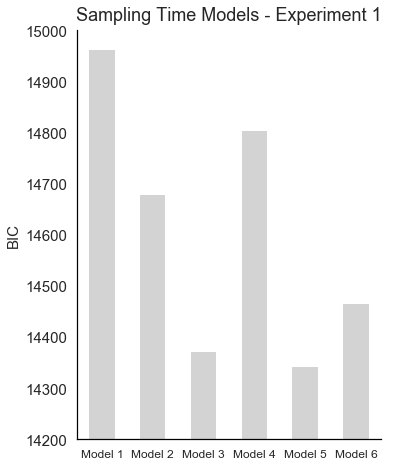

In [119]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS1['model'], DFBICS1['study1'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([14200,15000])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Sampling Time Models - Experiment 1", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"), fontsize=12)
#ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()


#### Sampling Time Models Study 2

In [129]:
# re-index for z-scoring
Data2Free.reset_index(inplace=True)
Data2Free.index = range(1, len(Data2Free) + 1)
Data2Free['Participant']=Data2Free['participant']
Data2Free = Data2Free.set_index(['Participant', 'index'])

In [130]:
## z-score RT for inclusion in the model
Data2Free.head()
Data2Free['ZRT'] = (Data2Free['RT1']-Data2Free.groupby(level='Participant')['RT1'].mean())/Data2Free.groupby(level = 'Participant')['RT1'].std()
# Are the mean Z-scores all close to 0?
Data2Free.groupby(level=0)['ZRT'].mean()


Participant
1     8.018277e-17
2    -1.993115e-15
7    -1.876806e-16
9     6.522560e-16
10    2.555275e-17
11   -3.876969e-17
13    3.172066e-16
14    6.062170e-16
15   -2.215159e-15
17   -3.744800e-18
18    6.784696e-16
19    5.965246e-16
20    4.783211e-16
21    5.727341e-17
22   -1.858632e-16
24    3.876969e-16
25   -8.282616e-17
26   -4.692014e-16
Name: ZRT, dtype: float64

In [133]:
# load data in R
r_df = pandas2ri.py2ri(Data2Free)
%R -i r_df

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:67: UserWarning: Error while trying to convert the column "new_bias_bin". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.
  (name, str(e)))


In [134]:
%%R
# sampling model 1
sampling_model1 = lmer(ZDeltaSampling ~ Choice + (1 + Choice | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model1))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + (1 + Choice | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6154.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3548 -0.5923 -0.0042  0.6089  3.9369 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 participant (Intercept) 0.04504  0.2122        
             Choice      0.16269  0.4033   -1.00
 Residual                0.89256  0.9448        
Number of obs: 2244, groups:  participant, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) -0.24483    0.05714  -4.285
Choice       0.49713    0.10313   4.821

Correlation of Fixed Effects:
       (Intr)
Choice -0.935


In [135]:
%%R
# sampling model 2
sampling_model2 = lmer(ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model2))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ NonAbsDiff + (1 + NonAbsDiff | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6125.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.3313 -0.5944  0.0140  0.6188  3.9799 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr
 participant (Intercept) 0.0000000 0.00000      
             NonAbsDiff  0.0008251 0.02873   NaN
 Residual                0.8835597 0.93998      
Number of obs: 2244, groups:  participant, 18

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.003545   0.019874   0.178
NonAbsDiff  0.064476   0.008082   7.978

Correlation of Fixed Effects:
           (Intr)
NonAbsDiff 0.004 


In [136]:
%%R
# sampling model 3
sampling_model3 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model3))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + (1 + Choice + NonAbsDiff |  
    participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6040.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4713 -0.5911  0.0068  0.6132  4.1006 

Random effects:
 Groups      Name        Variance  Std.Dev. Corr       
 participant (Intercept) 3.878e-02 0.196933            
             Choice      1.467e-01 0.382995 -1.00      
             NonAbsDiff  2.073e-05 0.004554 -1.00  1.00
 Residual                8.452e-01 0.919334            
Number of obs: 2244, groups:  participant, 18

Fixed effects:
             Estimate Std. Error t value
(Intercept) -0.137017   0.054471  -2.515
Choice       0.279257   0.100175   2.788
NonAbsDiff   0.049887   0.004576  10.902

Correlation of Fixed Effects:
           (Intr) Choice
Choice     -0.933       
NonAbsDiff -0.029  0.024


In [137]:
%%R
# sampling model 4
sampling_model4 = lmer(ZDeltaSampling ~ Choice + ZConf1 + Choice*ZConf1 + (1 + Choice + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model4))

Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + ZConf1 + Choice * ZConf1 + (1 + Choice +  
    ZConf1 + Choice * ZConf1 | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6146.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1586 -0.5844 -0.0151  0.6288  4.1489 

Random effects:
 Groups      Name          Variance Std.Dev. Corr             
 participant (Intercept)   0.000000 0.00000                   
             Choice        0.032558 0.18044    NaN            
             ZConf1        0.006573 0.08107    NaN -0.64      
             Choice:ZConf1 0.007796 0.08829    NaN  0.98 -0.78
 Residual                  0.888567 0.94264                   
Number of obs: 2244, groups:  participant, 18

Fixed effects:
              Estimate Std. Error t value
(Intercept)   -0.23440    0.02749  -8.526
Choice         0.49010    0.05846   8.384
ZConf1        -0.13950    0.03411

In [138]:
%%R
# sampling model 5
sampling_model5 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 + (1 + Choice + NonAbsDiff + ZConf1 + Choice*ZConf1 | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model5))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 +  
    (1 + Choice + NonAbsDiff + ZConf1 + Choice * ZConf1 | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6012.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.4947 -0.5902 -0.0023  0.6129  4.2636 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                   
 participant (Intercept)   4.415e-02 0.210112                        
             Choice        1.629e-01 0.403625 -1.00                  
             NonAbsDiff    2.982e-05 0.005461 -0.18  0.13            
             ZConf1        1.073e-02 0.103594  0.54 -0.59  0.73      
             Choice:ZConf1 1.360e-02 0.116604 -0.92  0.94 -0.22 -0.83
 Residual                  8.276e-01 0.909709                        
Number of obs: 2244, groups:  participant, 18

Fixed effects:
               Estima

In [139]:
%%R
# sampling model 6
sampling_model6 = lmer(ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT + (1 + Choice + NonAbsDiff + ZConf1 + ZRT + Choice*ZConf1 + Choice*ZRT | participant), control = lmerControl(optimizer='bobyqa', calc.derivs = FALSE), data=r_df)
print(summary(sampling_model6))


Linear mixed model fit by REML ['lmerMod']
Formula: ZDeltaSampling ~ Choice + NonAbsDiff + ZConf1 + ZRT + Choice *  
    ZConf1 + Choice * ZRT + (1 + Choice + NonAbsDiff + ZConf1 +  
    ZRT + Choice * ZConf1 + Choice * ZRT | participant)
   Data: r_df
Control: lmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

REML criterion at convergence: 6012.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7107 -0.5741 -0.0042  0.6096  4.2932 

Random effects:
 Groups      Name          Variance  Std.Dev. Corr                         
 participant (Intercept)   4.431e-02 0.210508                              
             Choice        1.661e-01 0.407587 -1.00                        
             NonAbsDiff    3.601e-05 0.006001  0.07 -0.07                  
             ZConf1        1.123e-02 0.105955  0.50 -0.50  0.54            
             ZRT           1.243e-02 0.111483 -0.50  0.50  0.22  0.11      
             Choice:ZConf1 1.461e-02 0.120862 -0.83  0.83 -0.12 -0.83

In [140]:
%%R
# compute BIC scores for each model
print(BIC(sampling_model1))
print(BIC(sampling_model2))
print(BIC(sampling_model3))
print(BIC(sampling_model4))
print(BIC(sampling_model5))
print(BIC(sampling_model6))

[1] 6200.406
[1] 6171.456
[1] 6117.795
[1] 6262.32
[1] 6174.874
[1] 6289.999


In [141]:
%R BIC1 <- BIC(sampling_model1)
%R BIC2 <- BIC(sampling_model2)
%R BIC3 <- BIC(sampling_model3)
%R BIC4 <- BIC(sampling_model4)
%R BIC5 <- BIC(sampling_model5)
%R BIC6 <- BIC(sampling_model6)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4
%R -o BIC5
%R -o BIC6

In [144]:
# create new dataframe with BIC scores
BICsampling2 = []
DFBICS2=pd.DataFrame(data=BICsampling2)
DFBICS2['model']=[0,1,2,3,4,5]
DFBICS2['study2']=[BIC1, BIC2, BIC3, BIC4, BIC5, BIC6]


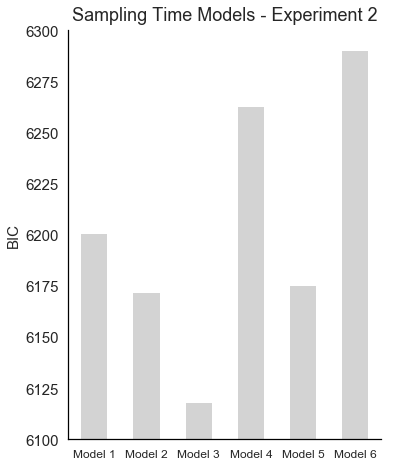

In [155]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS2['model'], DFBICS2['study2'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([6100,6300])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Sampling Time Models - Experiment 2", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6"), fontsize=12)
# ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('modelcomp_samp_s2.pdf')


#### Change of Mind Models Study 1

In [218]:
# load data in R
r_df = pandas2ri.py2ri(Data1)
%R -i r_df

In [161]:
%%R
# change of mind model 1
changemodel1 = glmer(Change ~ DDsqrt + (1 + DDsqrt | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel1))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + (1 + DDsqrt | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  5976.5   6009.7  -2983.3   5966.5     5595 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.9564 -0.5768 -0.5027 -0.3441  3.2838 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 participant (Intercept) 0.242033 0.49197       
             DDsqrt      0.002133 0.04618  -1.00
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.50533    0.17688  -2.857  0.00428 ** 
DDsqrt      -0.32350    0.06642  -4.871 1.11e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
DDsqrt -0.893


In [167]:
%%R
# change of mind model 2
changemodel2 = glmer(Change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel2))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4873.7   4933.4  -2427.9   4855.7     5591 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1321 -0.5232 -0.3096 -0.1033 10.0435 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 participant (Intercept) 0.249952 0.49995             
             DDsqrt      0.002377 0.04875  -0.61      
             ZBias       0.303103 0.55055  -0.13  0.86
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.94549    0.19657  -4.810 1.51e-06 ***
DDsqrt      -0.29318    0.07601  -3.857 0.000115 ***
ZBias       -1.27897    0.11440 -11.180  < 2e-16 ***
---
Signif. codes:  0 

In [168]:
%%R
# change of mind model 3
changemodel3 = glmer(Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel3))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 |  
    participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4668.0   4760.8  -2320.0   4640.0     5586 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9698 -0.4983 -0.2696 -0.0795 10.4281 

Random effects:
 Groups      Name        Variance Std.Dev. Corr             
 participant (Intercept) 0.311488 0.5581                    
             DDsqrt      0.001005 0.0317   -1.00            
             ZBias       0.284694 0.5336    0.02 -0.02      
             ZConf1      0.046305 0.2152    0.45 -0.45 -0.16
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.17566    0.20793  -5.654 1.57e-08 ***
DDsqrt      -0.2396

In [169]:
%%R
# change of mind model 4
changemodel4 = glmer(Change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias + ZConf1 + ZRT | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel4))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias +  
    ZConf1 + ZRT | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4660.4   4793.0  -2310.2   4620.4     5580 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9837 -0.4946 -0.2651 -0.0817 10.9146 

Random effects:
 Groups      Name        Variance Std.Dev. Corr                   
 participant (Intercept) 0.368173 0.60677                         
             DDsqrt      0.006862 0.08284  -0.74                  
             ZBias       0.291239 0.53967  -0.14  0.47            
             ZConf1      0.029849 0.17277   0.48 -0.85 -0.22      
             ZRT         0.013188 0.11484  -0.67  0.72 -0.09 -0.53
Number of obs: 5600, groups:  participant, 28

Fixed effects:
            Esti

In [170]:
%%R
# compute BIC scores for each model
print(BIC(changemodel1))
print(BIC(changemodel2))
print(BIC(changemodel3))
print(BIC(changemodel4))

[1] 6009.675
[1] 4933.396
[1] 4760.788
[1] 4792.994


In [171]:
%R BIC1 <- BIC(changemodel1)
%R BIC2 <- BIC(changemodel2)
%R BIC3 <- BIC(changemodel3)
%R BIC4 <- BIC(changemodel4)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4

In [172]:
# create new dataframe with BIC scores
BICsampling1 = []
DFBICS1=pd.DataFrame(data=BICsampling1)
DFBICS1['model']=[0,1,2,3]
DFBICS1['study1']=[BIC1, BIC2, BIC3, BIC4]


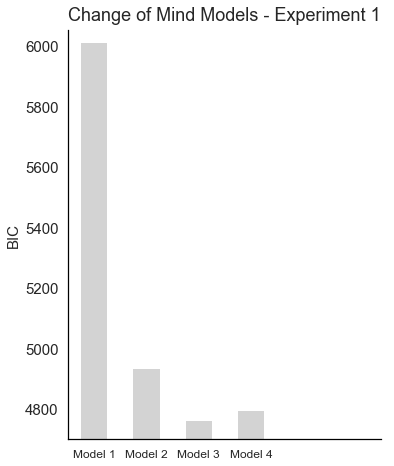

In [175]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS1['model'], DFBICS1['study1'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([4700,6050])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Change of Mind Models - Experiment 1", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4"), fontsize=12)
# ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('modelcomp_change_S1.pdf')


#### Change of Mind Models Study 2

In [217]:
## z-score RT for inclusion in the model
Data2.head()
Data2['ZRT'] = (Data2['RT1']-Data2.groupby(level='Participant')['RT1'].mean())/Data2.groupby(level = 'Participant')['RT1'].std()
# Are the mean Z-scores all close to 0?
Data2.groupby(level=0)['ZRT'].mean()


Participant
1    -3.398131e-16
2    -6.539700e-16
7    -3.745275e-16
9     7.066658e-16
10    2.528841e-16
11    6.595253e-16
13    8.635068e-17
14    4.565902e-16
15   -1.739349e-15
17    4.739375e-16
18   -8.748937e-16
19    1.097006e-16
20    1.374239e-16
21   -8.405974e-16
22    1.323787e-15
24   -3.678715e-16
25    2.436323e-16
26   -1.903239e-16
Name: ZRT, dtype: float64

In [219]:
# load data in R
r_df = pandas2ri.py2ri(Data2)
%R -i r_df

In [186]:
%%R
# change of mind model 1
changemodel1 = glmer(change ~ DDsqrt + (1 + DDsqrt | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel1))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + (1 + DDsqrt | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4476.4   4508.5  -2233.2   4466.4     4495 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3086 -0.5159 -0.4512 -0.3676  2.8283 

Random effects:
 Groups      Name        Variance Std.Dev. Corr 
 participant (Intercept) 0.52503  0.7246        
             DDsqrt      0.02863  0.1692   -1.00
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.70763    0.22959  -3.082  0.00206 ** 
DDsqrt      -0.33781    0.08278  -4.081 4.49e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
       (Intr)
DDsqrt -0.925


In [195]:
%%R
# change of mind model 2
changemodel2 = glmer(change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel2))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + (1 + DDsqrt + ZBias | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4447.2   4504.9  -2214.6   4429.2     4491 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.2813 -0.5256 -0.4413 -0.3249  5.0611 

Random effects:
 Groups      Name        Variance Std.Dev. Corr       
 participant (Intercept) 0.55337  0.7439              
             DDsqrt      0.03609  0.1900   -0.94      
             ZBias       0.05937  0.2437    0.10  0.24
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.70697    0.23383  -3.024   0.0025 ** 
DDsqrt      -0.35577    0.08580  -4.146 3.38e-05 ***
ZBias       -0.17764    0.06901  -2.574   0.0100 *  
---
Signif. codes:  0 

In [197]:
%%R
# change of mind model 3
changemodel3 = glmer(change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel3))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + ZConf1 + (1 + DDsqrt + ZBias + ZConf1 |  
    participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4208.1   4297.8  -2090.0   4180.1     4486 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4077 -0.5036 -0.3824 -0.2430  4.5449 

Random effects:
 Groups      Name        Variance Std.Dev. Corr             
 participant (Intercept) 0.79116  0.8895                    
             DDsqrt      0.05050  0.2247   -0.98            
             ZBias       0.06101  0.2470    0.16  0.02      
             ZConf1      0.04565  0.2136    0.27 -0.32 -0.26
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.06296    0.26628  -3.992 6.56e-05 ***
DDsqrt      -0.2400

In [221]:
%%R
# change of mind model 4
changemodel4 = glmer(change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias + ZConf1 + ZRT | participant), data=r_df, control = glmerControl(optimizer='bobyqa', calc.derivs = FALSE), family="binomial")
print(summary(changemodel4))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + ZConf1 + ZRT + (1 + DDsqrt + ZBias +  
    ZConf1 + ZRT | participant)
   Data: r_df
Control: glmerControl(optimizer = "bobyqa", calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
  4214.1   4342.3  -2087.1   4174.1     4480 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0470 -0.5036 -0.3812 -0.2395  4.6073 

Random effects:
 Groups      Name        Variance Std.Dev. Corr                   
 participant (Intercept) 0.794288 0.89123                         
             DDsqrt      0.050936 0.22569  -0.98                  
             ZBias       0.060650 0.24627   0.15  0.06            
             ZConf1      0.050633 0.22502   0.25 -0.28 -0.23      
             ZRT         0.007894 0.08885  -0.02  0.12  0.40  0.73
Number of obs: 4500, groups:  participant, 18

Fixed effects:
            Esti

In [224]:
%%R
# change of mind model 5
changemodel5 <- glmer(change ~ DDsqrt + ZBias + ZConf1 + FixedSampling + FixedSampling*ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling*ZBias | participant), data=r_df, control = glmerControl(optimizer='nlminbw'), family="binomial")
print(summary(changemodel5))


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: change ~ DDsqrt + ZBias + ZConf1 + FixedSampling + FixedSampling *  
    ZBias + (1 + ZBias + DDsqrt + ZConf1 + FixedSampling + FixedSampling *  
    ZBias | participant)
   Data: r_df
Control: glmerControl(optimizer = "nlminbw")

     AIC      BIC   logLik deviance df.resid 
  4080.5   4253.6  -2013.3   4026.5     4473 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5425 -0.4985 -0.3538 -0.1898  5.2782 

Random effects:
 Groups      Name                Variance Std.Dev. Corr                   
 participant (Intercept)         0.83911  0.9160                          
             ZBias               0.43469  0.6593    0.45                  
             DDsqrt              0.04165  0.2041   -0.99 -0.33            
             ZConf1              0.04578  0.2140    0.23  0.70 -0.14      
             FixedSampling       0.24614  0.4961   

In [226]:
%%R
# compute BIC scores for each model
print(BIC(changemodel1))
print(BIC(changemodel2))
print(BIC(changemodel3))
print(BIC(changemodel4))
print(BIC(changemodel5))

[1] 4508.505
[1] 4504.921
[1] 4297.82
[1] 4342.344
[1] 4253.645


In [227]:
%R BIC1 <- BIC(changemodel1)
%R BIC2 <- BIC(changemodel2)
%R BIC3 <- BIC(changemodel3)
%R BIC4 <- BIC(changemodel4)
%R BIC5 <- BIC(changemodel5)
%R -o BIC1
%R -o BIC2
%R -o BIC3
%R -o BIC4
%R -o BIC5

In [228]:
# create new dataframe with BIC scores
BICsampling2 = []
DFBICS2=pd.DataFrame(data=BICsampling2)
DFBICS2['model']=[0,1,2,3,4]
DFBICS2['study2']=[BIC1, BIC2, BIC3, BIC4, BIC5]


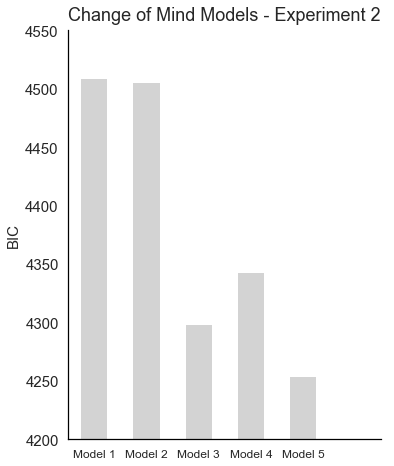

In [230]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(6, 7)
ind = np.arange(1)
margin = 0.05
width = (0.8-1.0*margin)

ax.bar(DFBICS2['model'], DFBICS2['study2'], 0.5, align='center', color='lightgray', edgecolor='none') # create bar graphs
# axes limits
ax.set_xlim([-0.5,5.5])
ax.set_ylim([4200,4550])

# add some text for labels, title and axes ticks
ax.set_ylabel("BIC", fontsize=15)
ax.set_title("Change of Mind Models - Experiment 2", fontsize=18)
ttl = ax.title
ttl.set_position([0.5, 1.01])
ax.set_xticks((np.arange(6)))
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xticklabels(("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"), fontsize=12)
# ax.set_axis_bgcolor('white')

#sns.set_style('darkgrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'})

sns.despine(right=True, top=True)
grid(False)
plt.tight_layout()
savefig('modelcomp_change_S2.pdf')


<a id=Functions></a>

### Functions used

In [41]:
# plotting psychometric curves
def logistic_regression(subjects, data):
    def model(x):
        y = 1 / (1 + np.exp(-x))
        return y
    #run the classifier
    clf = sklearn.linear_model.LogisticRegression(C=1e5)
    logit1 = []
    logit2 = []
    plot = fig.add_subplot(1,1,1)

    # plot data points choice 1
    mean_prob_choice = []
    errors = []
    rankdiffs = range(-15,16)
    for y in rankdiffs:
        mean_prob_choice.append(mean(data[data['NonAbsDiff']==y]['Left1']))
        errors.append(stats.sem(data[data['NonAbsDiff']==y]['Left1']))
    plt.errorbar(rankdiffs, mean_prob_choice, yerr=errors, fmt='o', label='Choice 1', color='#3C91E6')

    # plot data points choice 2
    mean_prob_choice = []
    errors = []
    for y in rankdiffs:
        mean_prob_choice.append(mean(data[data['NonAbsDiff']==y]['Left2']))
        errors.append(stats.sem(data[data['NonAbsDiff']==y]['Left2']))
    plt.errorbar(rankdiffs, mean_prob_choice, yerr=errors, fmt='o', label='Choice 2', color='#EA8B4C')
    
    X_test = np.linspace(-16,16,300)
    # get fit choice 1
    clf.fit(data['NonAbsDiff'][:, np.newaxis], data['Left1'])
    logit1 = model(X_test*clf.coef_).ravel()

    # get fit choice 2
    clf.fit(data['NonAbsDiff'][:, np.newaxis], data['Left2'])
    logit2 = model(X_test*clf.coef_).ravel()
    
    #plt fits
    plot.plot(X_test, logit1, linewidth=3, color='#3C91E6')
    plot.plot(X_test, logit2, linewidth=3, color='#EA8B4C')

    plot.set_ylabel('Prob(Choice=Left)', size=24)
    plot.set_xlabel('Dot Difference (Left-Right)', size=24)
    plot.tick_params(axis='both', which='major', labelsize=20)

    plot.set_ylim(0, 1.01)
    plot.set_xlim(-15.5, 15.5)
    plot.grid(True)
    grid(False)
    plt.legend(prop={'size':20})    
    sns.despine(right=True, top=True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, left=0.15)